# Manual Network finding

This notebook will work finding the best trade-off for our own implemented neural network, using previous data transformation

**Main goals are**: 
- Expose results that will be compared to ML ones

In [1]:
from local_lib.dataset import retreiveDatasetFromCsv
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
from local_lib.flatten_transformer import FlattenTransformer
from local_lib.dimension_transformer import DimensionTransformer
import numpy as np
from sklearn.decomposition import PCA

dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

pipeline = Pipeline([
    ('flatten_tr', FlattenTransformer()),
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('dimension_tr', DimensionTransformer())])

In [2]:
# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

pca = PCA(n_components=50)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X.shape

(5856, 50)

**Need to transpose input and output layers because we used transposed version of LogLoss for more explicit visualization**

In [3]:
import numpy as np
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)
X_train = X_train.T
X_test = X_test.T

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50, 3923)
(50, 1933)
(1, 3923)
(1, 1933)


**Instantiate a sample neural network**

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

class MultiClassNeuralNetwork():
    def __init__(self, X, y, dimensions = (16, 16, 16), lr=0.1, n_iter=1000, test_size=0.2):
        self.lr = lr
        self.n_iter = n_iter
        self.test_size = test_size
        self.dimensions = list(dimensions)
        self.dimensions.insert(0, X.shape[0])
        self.dimensions.append(y.shape[0])
        self.parameters = {}

        self.classes = np.unique(y)
        self.output_act = []
        self.divider  = len(np.unique(y)) + 1
        bornes = np.linspace(0,1, self.divider)
        self.output_act = []
        self.mapped_classes = {}

        for i in range(0, len(self.classes)):
            self.output_act.append([round(bornes[i], 2), round(bornes[i + 1], 2), self.classes[i]])
            self.mapped_classes[i] = round((round(bornes[i], 2) + round(bornes[i + 1], 2)) / 2, 2)
        print(self.mapped_classes)
        print(self.output_act)

        # Initialisation de W1, b1, ...
        C = len(self.dimensions)
        for c in range(1, C):
            self.parameters['W' + str(c)] = np.random.randn(self.dimensions[c], self.dimensions[c - 1])
            self.parameters['b' + str(c)] = np.random.randn(self.dimensions[c], 1)

    def get_corresponding_classes(self, acts):
        results = []


        for act in acts[0]:
            result = 0
            for i in range(len(self.output_act)):
                if self.output_act[i][0] <= act < self.output_act[i][1]:
                    result = self.output_act[i][2]
                    break  # On peut arrêter la boucle une fois que la classe correspondante est trouvée
            results.append(result)
        return np.array(results).reshape(1, -1)

    def forward_propagation(self, X):
        activations = {'A0': X}

        C = len(self.parameters) // 2

        for c in range(1, C + 1):

            Z = self.parameters['W' + str(c)].dot(activations['A' + str(c - 1)]) + self.parameters['b' + str(c)]
            activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

        return activations
    
    def back_propagation(self, y, activations):

        m = y.shape[1]
        C = len(self.parameters) // 2
        dZ = activations['A' + str(C)] - y
        gradients = {}

        for c in reversed(range(1, C + 1)):
            gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
            gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            #N'a pas de sens pour Z0
            if c > 1:
                dZ = np.dot(self.parameters['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

        return gradients

    def update(self, gradients):

        C = len(self.parameters) // 2

        for c in range(1, C + 1):
            self.parameters['W' + str(c)] = self.parameters['W' + str(c)] - self.lr * gradients['dW' + str(c)]
            self.parameters['b' + str(c)] = self.parameters['b' + str(c)] - self.lr * gradients['db' + str(c)]

        return

    def predict(self, X):
        activations = self.forward_propagation(X)
        C = len(self.parameters) // 2
        Af = activations['A' + str(C)]
        return self.get_corresponding_classes(Af)
    
    def log_loss(self, A, y):
        #Calcule du cout pour une itération
        epsilon = 1e-15
        return 1 / len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

    def fit(self, X_train, X_test, y_train, y_test):

        training_history = np.zeros((int(self.n_iter), 3))

        C = len(self.parameters) // 2
        y_train_adjusted = np.array([self.mapped_classes[val] for val in y_train[0]]).reshape(1, -1)
        y_test_adjusted = np.array([self.mapped_classes[val] for val in y_test[0]]).reshape(1, -1)

        # gradient descent
        for i in tqdm(range(self.n_iter)):

            activations = self.forward_propagation(X_train)
            gradients = self.back_propagation(y_train_adjusted, activations)
            self.update(gradients)
            Af = activations['A' + str(C)]
            # calcul du log_loss et de l'accuracy
            y_pred_train = self.predict(X_train)
            y_pred_test = self.predict(X_test)
            # training_history[i, 0] = (log_loss(y_train.flatten(), y_pred_train.flatten(), labels=self.classes))
            training_history[i, 0] = (self.log_loss(Af.flatten(), y_train_adjusted.flatten()))
            # training_history[i, 1] = (accuracy_score(y_train_adjusted.flatten(), y_pred_train.flatten()))
            # training_history[i, 2] = (accuracy_score(y_test_adjusted.flatten(), y_pred_test.flatten()))

        return training_history

In [11]:
y_train[0]

array([0, 2, 2, ..., 2, 2, 1])

In [40]:
mnn = MultiClassNeuralNetwork(X_train, y_train, dimensions=(128,128,128,128), n_iter=4000, lr=0.05)
hist = mnn.fit(X_train, X_test, y_train,y_test)

{0: 0.16, 1: 0.5, 2: 0.84}
[[0.0, 0.33, 0], [0.33, 0.67, 1], [0.67, 1.0, 2]]


  0%|          | 0/4000 [00:00<?, ?it/s]C:\Users\chapu\AppData\Local\Temp\ipykernel_26528\3016967319.py:57: RuntimeWarning: overflow encountered in exp
  activations['A' + str(c)] = 1 / (1 + np.exp(-Z))
100%|██████████| 4000/4000 [12:09<00:00,  5.49it/s]


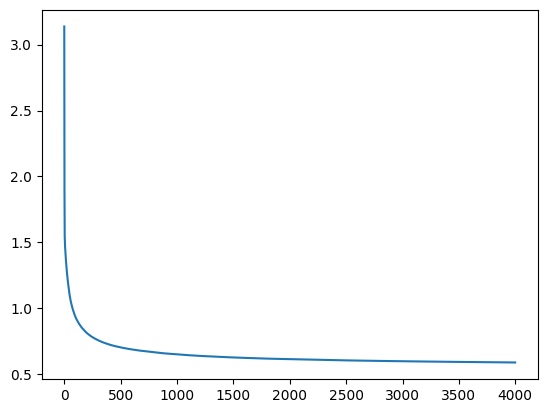

In [41]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[:, 0])
plt.show()

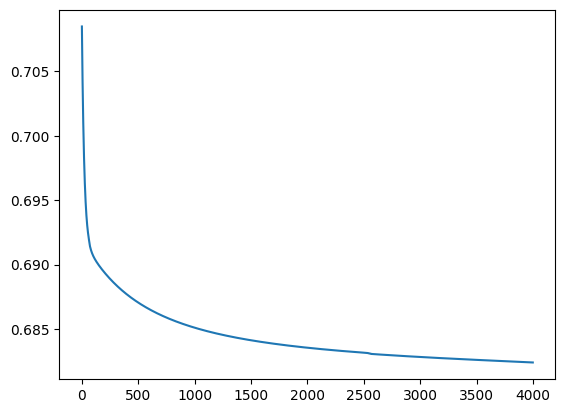

In [30]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[:, 0])
plt.show()

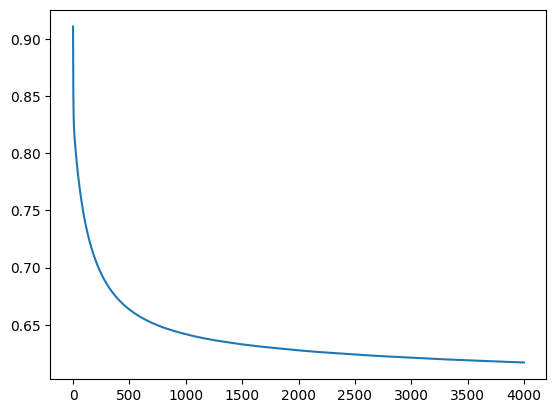

In [35]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[:, 0])
plt.show()

In [50]:
from local_lib.dataset import retreiveDatasetFromCsv
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
from local_lib.flatten_transformer import FlattenTransformer
from local_lib.dimension_transformer import DimensionTransformer
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('minmax', MinMaxScaler())])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)

In [49]:
np.unique(X_train)

array([0.00000000e+00, 7.59789183e-05, 1.05153927e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [36]:
y_pred_test = mnn.predict(X_test)

C:\Users\chapu\AppData\Local\Temp\ipykernel_26528\3016967319.py:57: RuntimeWarning: overflow encountered in exp
  activations['A' + str(c)] = 1 / (1 + np.exp(-Z))


In [37]:
np.unique(y_pred_test)

array([0, 1, 2])

In [33]:
np.unique(y_test)

array([0, 1, 2])

In [33]:
import numpy as np

classes = [0, 1, 2]

divider = len(np.unique(classes)) + 1
bornes = np.linspace(0,1, divider)
output_act = []

for i in range(0, len(classes)):

    output_act.append([round(1 * bornes[i], 2), round(1 * bornes[i + 1], 2), classes[i]])



pred = 0.67

def get_corresponding_classe(act):
    result = 0
    for i in range(0, len(output_act)):
        if(output_act[i][0] <= act < output_act[i][1]):
            result = output_act[i][2]

    return result
get_corresponding_classe(pred)

0
1
2
[[0.0, 0.33, 0], [0.33, 0.67, 1], [0.67, 1.0, 2]]


2